In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

### Loading the dinesafe data

In [2]:
datapath = r'../data/'

In [3]:
dfd = pd.read_csv(datapath + 'dinesafe.csv', parse_dates=['INSPECTION_DATE']).drop('Unnamed: 0', axis=1)
dfd.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED
0,1,1222579,103868579,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2016-12-21,M - Minor,Notice to Comply,,
1,2,1222579,104063869,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,NaN,2017-10-04,NaN,NaN,NaN,NaN
2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
3,4,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
4,5,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,


In [4]:
insp = dfd[['ESTABLISHMENT_ID', 'INSPECTION_DATE']].groupby('ESTABLISHMENT_ID').count().sort_values('INSPECTION_DATE', ascending=False)

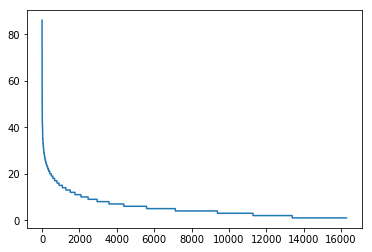

In [5]:
plt.plot(insp.values)
plt.show()

### Initial exploration

In [6]:
# Pass count
df_pass = dfd[['ESTABLISHMENT_STATUS', 'ROW_ID']].groupby('ESTABLISHMENT_STATUS').count()
df_pass['pct'] = df_pass['ROW_ID'] / df_pass['ROW_ID'].sum()
df_pass

,ROW_ID,pct
ESTABLISHMENT_STATUS,,
Closed,352,0.003889
Conditional Pass,17237,0.190422
Pass,72931,0.805689


min date: 2016-09-23
max date: 2018-09-21


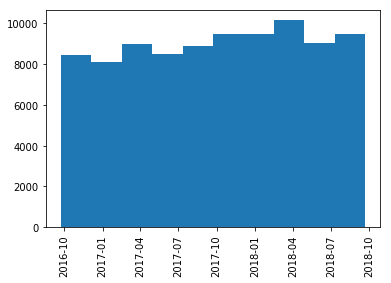

In [7]:
# time
plt.hist(dfd['INSPECTION_DATE'], bins=10)
plt.xticks(rotation='vertical')
print("min date: %s" % dfd['INSPECTION_DATE'].min().date())
print("max date: %s" % dfd['INSPECTION_DATE'].max().date())
plt.show()

In [8]:
# severity
df_severe = dfd[['SEVERITY', 'ROW_ID']].groupby('SEVERITY').count()
df_severe['pct'] = df_severe['ROW_ID'] / df_severe['ROW_ID'].sum()
df_severe

,ROW_ID,pct
SEVERITY,,
C - Crucial,2400,0.038899
M - Minor,32280,0.523194
NA - Not Applicable,4048,0.065610
S - Significant,22970,0.372297


### Fines

In [9]:
df_fined = dfd[(pd.notnull(dfd['AMOUNT_FINED'])) & (dfd['AMOUNT_FINED'] != ' ')].copy()
df_fined['COURT_OUTCOME'].unique()

array(['Conviction - Fined',
       'Conviction - Fined & Order to Close by Court',
       'Charges Withdrawn', 'Conviction - Suspended Sentence',
       'Charges Quashed'], dtype=object)

In [10]:
fine_map = {
    'Conviction - Fined': True,
    'Conviction - Fined & Order to Close by Court': True,
    'Charges Withdrawn': False, 
    'Conviction - Suspended Sentence': True,
    'Charges Quashed': False
}

In [11]:
df_fined['Convicted'] = df_fined['COURT_OUTCOME'].apply(lambda x: fine_map[x])
df_fined['dollar_amt'] = df_fined['AMOUNT_FINED'].apply(lambda x: float(x))

In [12]:
df_fined.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED,Convicted,dollar_amt
695,696,9001150,103920617,STARBUCKS,Restaurant,1088 YONGE ST,43.677997,-79.390257,Pass,1,Operate food premise - fail to keep facility s...,2017-02-28,M - Minor,Ticket,Conviction - Fined,65.00,True,65.0
853,854,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Fail to Hold a Valid Food Handler's Certificat...,2017-12-01,NA - Not Applicable,Ticket,Conviction - Fined,63.50,True,63.5
854,855,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operate food premise - fail to keep facility s...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
855,856,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operator fail to ensure room kept free from ma...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
858,859,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Store hazardous foods at internal temperature ...,2017-12-01,C - Crucial,Summons,Conviction - Fined,1130,True,1130.0


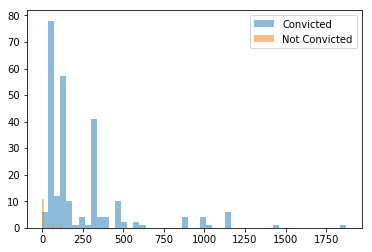

In [13]:
# any fines?
plt.hist(df_fined[df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Convicted', bins=50)
plt.hist(df_fined[~df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Not Convicted')
plt.legend()
plt.show()

In [16]:
dft = pd.read_pickle('results/tor_rest.p')

In [17]:
dft.shape

(10914, 14)

### Joining

In [18]:
dfd = dfd.set_index('ROW_ID')

In [19]:
# converting all to lower case
dfd['name'] = dfd['ESTABLISHMENT_NAME'].apply(lambda x: x.lower())
dfd['address'] = dfd['ESTABLISHMENT_ADDRESS'].apply(lambda x: x.lower())
dft['name'] = dft['name'].apply(lambda x: x.lower())
dft['address'] = dft['address'].apply(lambda x: x.lower())

display(dfd[:1][['name', 'address']])
print(dfd.shape)

display(dft[:1][['name', 'address']])
print(dft.shape)

,name,address
ROW_ID,,
1,sai-lila khaman dhokla house,870 markham rd


(90520, 17)


,name,address
business_id,,
9A2quhZLyWk0akUetBd8hQ,bnc cake house,631 bloor st w


(10914, 14)


In [20]:
dfd.columns

Index(['ESTABLISHMENT_ID', 'INSPECTION_ID', 'ESTABLISHMENT_NAME',
       'ESTABLISHMENTTYPE', 'ESTABLISHMENT_ADDRESS', 'LATITUDE', 'LONGITUDE',
       'ESTABLISHMENT_STATUS', 'MINIMUM_INSPECTIONS_PERYEAR',
       'INFRACTION_DETAILS', 'INSPECTION_DATE', 'SEVERITY', 'ACTION',
       'COURT_OUTCOME', 'AMOUNT_FINED', 'name', 'address'],
      dtype='object')

In [ ]:
# required combined address and name match score
CUT_OFF_SCORE = 0.8

total_count = dft.shape[0]
final_mapper = {}
for i, row in enumerate(dft.iterrows()):
    cur_bus_id = row[0]
    cur_name = row[1]['name']
    cur_addr = row[1]['address']
    print("processing (%s/%s) business: %s at address: %s with id: %s" % (i+1
                                                                          , total_count
                                                                          , cur_name
                                                                          , cur_addr
                                                                          , cur_bus_id))
    
    dfd['match_name'] = dfd['name'].apply(lambda x: fuzz.partial_ratio(x, cur_name))
    dfd['match_addr'] = dfd['address'].apply(lambda x: fuzz.partial_ratio(x, cur_addr))
    dfd['score'] = (dfd['match_name'] /  100) * (dfd['match_addr'] / 100)
    dfd = dfd.sort_values('score', ascending=False)
    if dfd['score'].values[0] > CUT_OFF_SCORE:
        print("\n!!! Found Match for \n(%s, %s) in the dinesafe db \n at (ROW_ID: %s, %s, %s)" % (cur_name
                                                                                       , cur_addr
                                                                                       , dfd.index[0]
                                                                                       , dfd['name'].values[0]
                                                                                       , dfd['address'].values[0]))
        final_mapper[cur_bus_id] = dfd.index[0]

# exporting
df_map = pd.DataFrame(final_mapper, index=['mapped_ROW_ID']).T
df_map.index.name = 'yelp_business_id'
df_map.to_pickle('univ/mapped_dinesafe.p')

In [ ]:
# run full data set, report reviews, restaurants, labels